# MS vs APPL

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


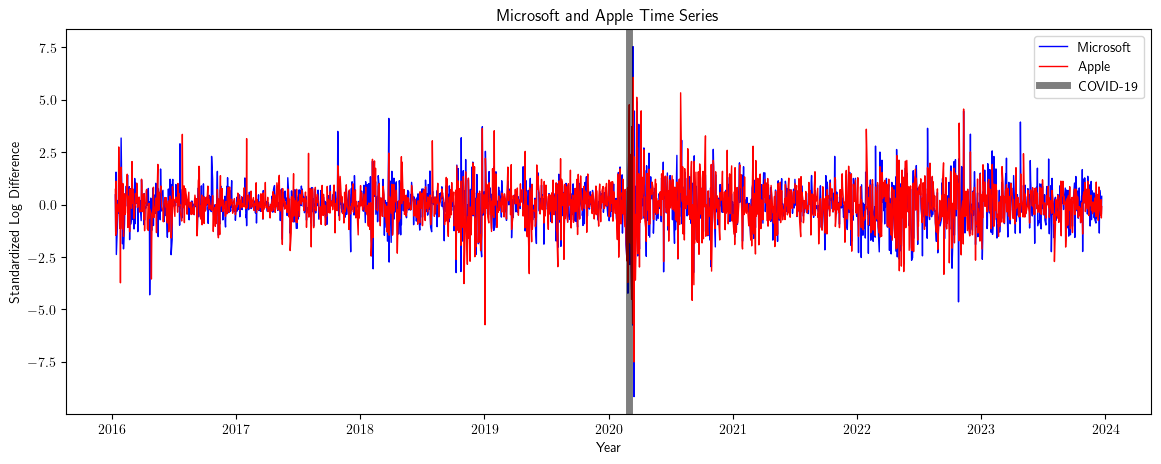

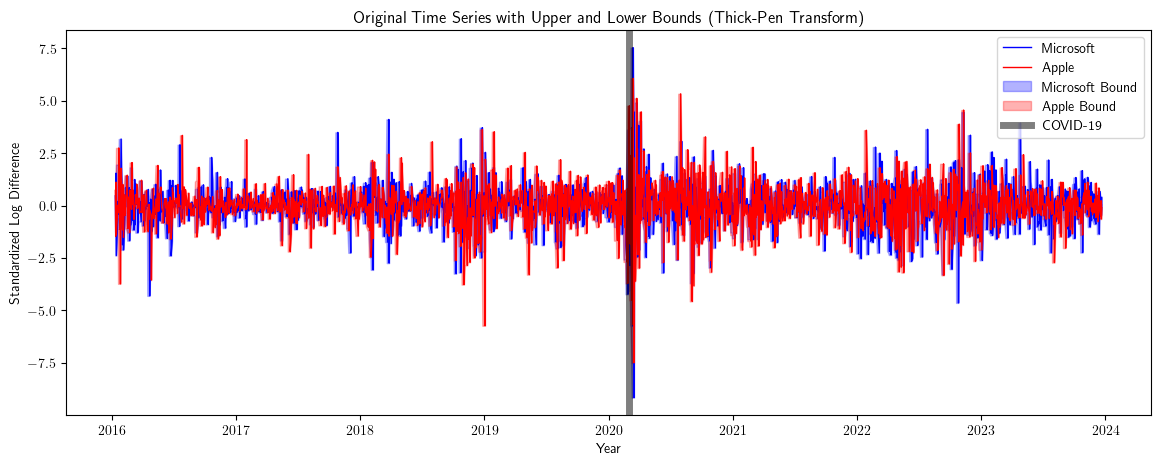

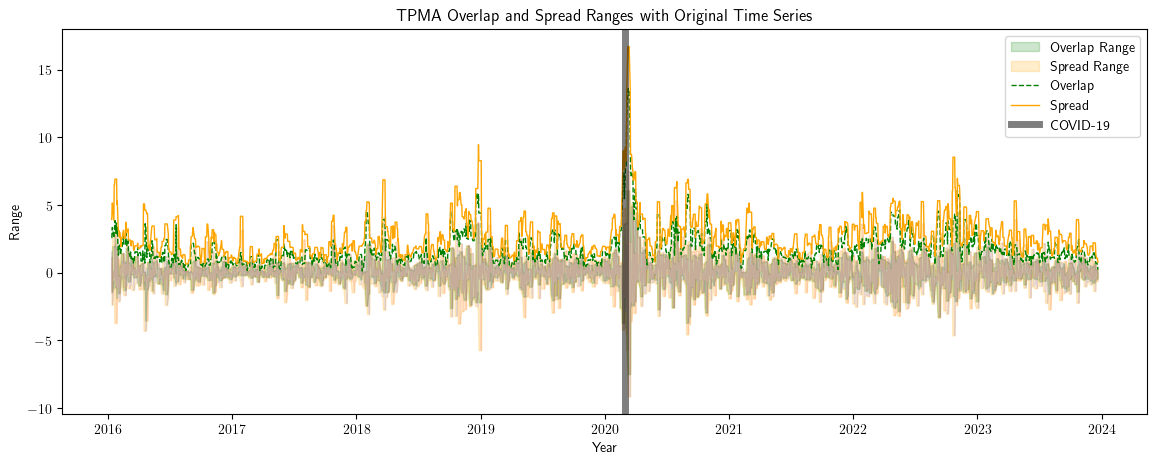

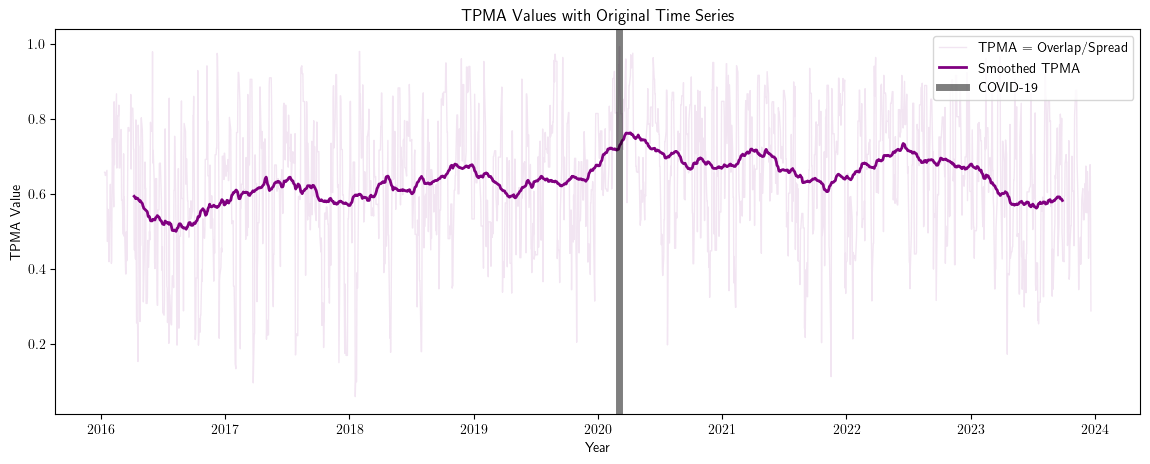

In [5]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
#    "font.family": "Helvetica"
})
# 데이터 크롤링 (최근 8년)
start_date = '2016-01-01'
end_date = '2024-01-01'
microsoft = yf.download('MSFT', start=start_date, end=end_date)
apple = yf.download('AAPL', start=start_date, end=end_date)

# 로그 변환 및 차분
log_microsoft = np.log(microsoft['Close'])
log_apple = np.log(apple['Close'])
diff_log_microsoft = log_microsoft.diff().dropna()
diff_log_apple = log_apple.diff().dropna()

# 표준화 함수
def standardize(series):
    return (series - series.mean()) / series.std()

# 차분 데이터 표준화
std_diff_log_microsoft = standardize(diff_log_microsoft)
std_diff_log_apple = standardize(diff_log_apple)

# 두꺼운펜변환 함수 (사각펜)
def thick_pen_transform(X, tau, gamma=0.001):
    n = len(X)
    U_tau = np.zeros(n)
    L_tau = np.zeros(n)
    
    for t in range(n - tau):
        U_tau[t] = np.max(X[t:t+tau+1]) + gamma * (tau / 2)
        L_tau[t] = np.min(X[t:t+tau+1]) - gamma * (tau / 2)
    
    # 경계 케이스 처리
    for t in range(n - tau, n):
        U_tau[t] = np.max(X[t:n]) + gamma * (tau / 2)
        L_tau[t] = np.min(X[t:n]) - gamma * (tau / 2)
    
    return L_tau, U_tau

tau = 5  # 두께 파라미터 설정
X = std_diff_log_microsoft.values
Y = std_diff_log_apple.values
dates = diff_log_microsoft.index

X_L_tau, X_U_tau = thick_pen_transform(X, tau)
Y_L_tau, Y_U_tau = thick_pen_transform(Y, tau)

# 코로나 시작 지점 설정
covid_start = '2020-03-01'
covid_start_idx = np.where(dates >= covid_start)[0][0]

# Upper와 Lower 각각 시각화 함수
def plot_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(dates[tau:-tau], X[tau:-tau], label='Microsoft', color='blue', linewidth=1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], label='Apple', color='red', linewidth=1)
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')

    plt.legend(loc='upper right')
    plt.title('Microsoft and Apple Time Series')
    plt.xlabel('Year')
    plt.ylabel('Standardized Log Difference')
    plt.show()

# 시각화
plot_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)


# Upper와 Lower 각각 시각화 함수
def plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(dates[tau:-tau], X[tau:-tau], label='Microsoft', color='blue', linewidth=1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], label='Apple', color='red', linewidth=1)
    
    plt.fill_between(dates[tau:-tau], X_L_tau[tau:-tau], X_U_tau[tau:-tau], color='blue', alpha=0.3, label='Microsoft Bound')
    plt.fill_between(dates[tau:-tau], Y_L_tau[tau:-tau], Y_U_tau[tau:-tau], color='red', alpha=0.3, label='Apple Bound')
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
    
    plt.legend(loc='upper right')
    plt.title('Original Time Series with Upper and Lower Bounds (Thick-Pen Transform)')
    plt.xlabel('Year')
    plt.ylabel('Standardized Log Difference')
    plt.show()

# 시각화
plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# TPMA의 분자와 분모 각각 시각화 함수
def plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    
    overlap_range = [min(X_U_tau[t], Y_U_tau[t]) - max(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    spread_range = [max(X_U_tau[t], Y_U_tau[t]) - min(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    
    plt.plot(dates[tau:-tau], X[tau:-tau], color='blue', linewidth=1, alpha=0.1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], color='red', linewidth=1, alpha=0.1)
    
    # 분자와 분모에 해당하는 음영 추가
    plt.fill_between(dates[tau:-tau], [max(X_L_tau[t], Y_L_tau[t]) for t in range(tau, len(X)-tau)], 
                     [min(X_U_tau[t], Y_U_tau[t]) for t in range(tau, len(X)-tau)], color='green', alpha=0.2, label='Overlap Range')
    plt.fill_between(dates[tau:-tau], [min(X_L_tau[t], Y_L_tau[t]) for t in range(tau, len(X)-tau)], 
                     [max(X_U_tau[t], Y_U_tau[t]) for t in range(tau, len(X)-tau)], color='orange', alpha=0.2, label='Spread Range')
    
    plt.plot(dates[tau:-tau], overlap_range[tau:-tau], color='green', linestyle='--', linewidth=1, label='Overlap')
    plt.plot(dates[tau:-tau], spread_range[tau:-tau], color='orange', linestyle='-', linewidth=1, label='Spread')
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')

    plt.legend(loc='upper right')
    plt.title('TPMA Overlap and Spread Ranges with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('Range')
    plt.show()

# 시각화
plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# 두꺼운펜 변환 상관계수 계산 함수
def rho_tau(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau):
    rho_tau_t = np.zeros(len(X))
    
    for t in range(len(X)):
        min_U = min(X_U_tau[t], Y_U_tau[t])
        max_L = max(X_L_tau[t], Y_L_tau[t])
        max_U = max(X_U_tau[t], Y_U_tau[t])
        min_L = min(X_L_tau[t], Y_L_tau[t])
        
        rho_tau_t[t] = (min_U - max_L) / (max_U - min_L)
    
    return rho_tau_t

# TPMA 계산
rho_values = rho_tau(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau)

# TPMA 값 시각화 함수
def plot_tpma_values_with_series(rho_values, dates, tau):
    plt.figure(figsize=(14, 5))
    
    # 원본 TPMA 값 플로팅
    plt.plot(dates[tau:-tau], rho_values[tau:-tau], label='TPMA = Overlap/Spread', color='purple', linewidth=1, alpha=0.1)
    
    # Smoothed line 추가 (이동 평균)
    window_size = 120
    smoothed_rho = np.convolve(rho_values[tau:-tau], np.ones(window_size)/window_size, mode='valid')
    plt.plot(dates[tau + window_size//2: -tau - window_size//2 + 1], smoothed_rho, label='Smoothed TPMA', color='purple', linewidth=2)
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
    
    plt.legend(loc='upper right')
    plt.title('TPMA Values with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('TPMA Value')
    plt.show()

# 시각화
plot_tpma_values_with_series(rho_values, dates, tau)


# MS vs Meta

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

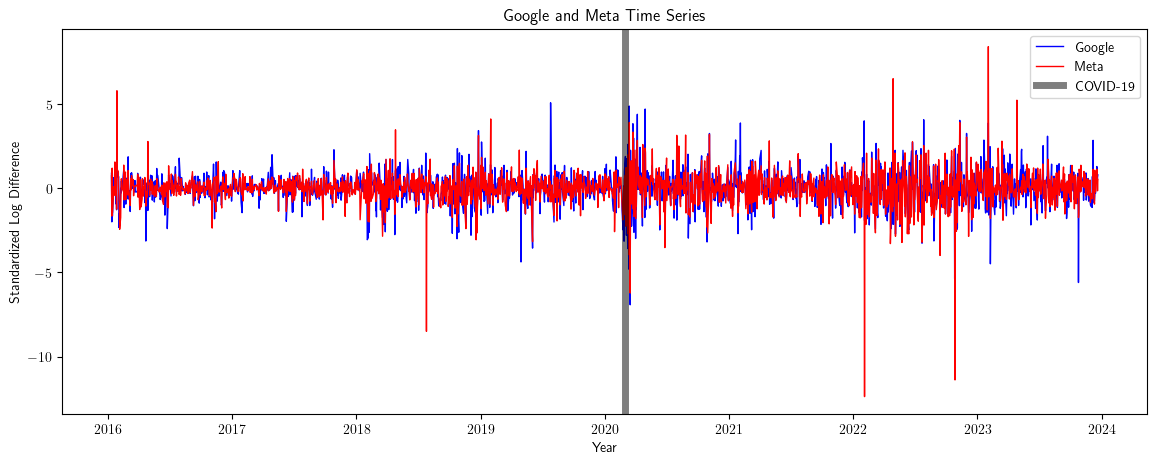

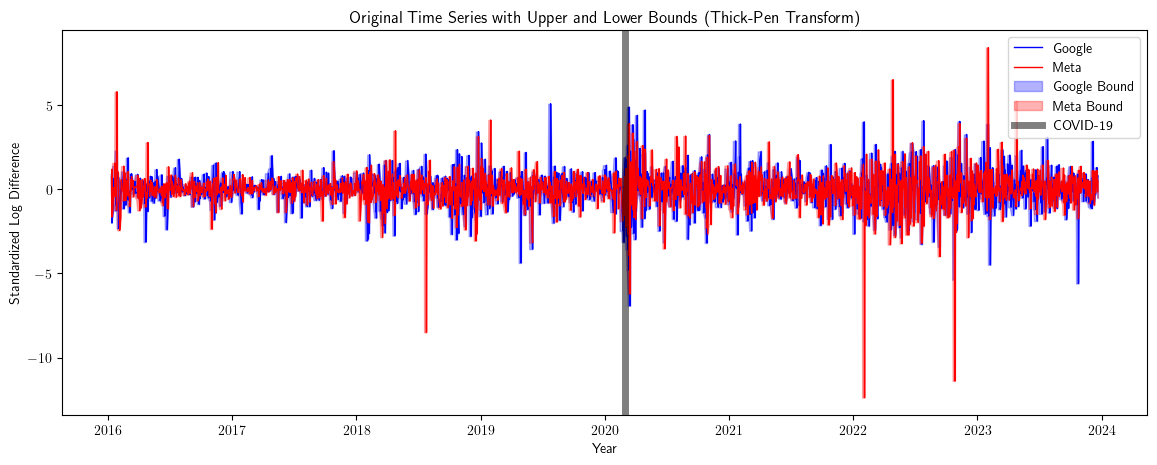

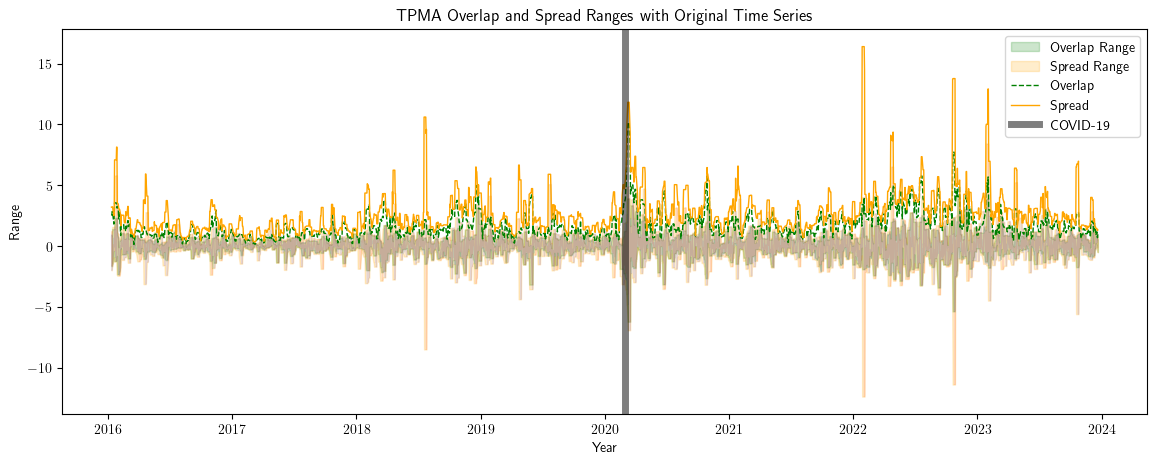

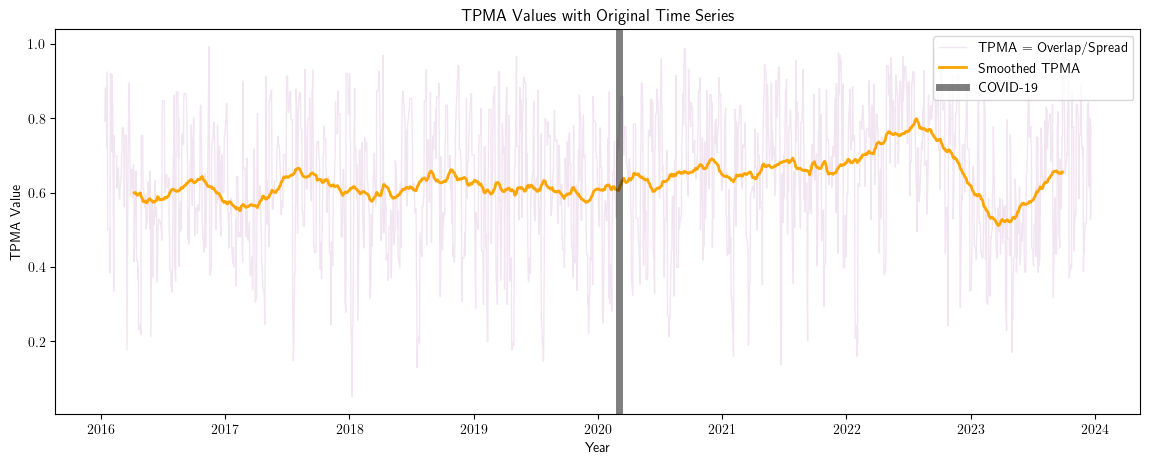

In [86]:
# 데이터 크롤링 (최근 8년)
start_date = '2016-01-01'
end_date = '2024-01-01'
google = yf.download('GOOGL', start=start_date, end=end_date)
meta = yf.download('META', start=start_date, end=end_date)

# 로그 변환 및 차분
log_google = np.log(google['Close'])
log_meta = np.log(meta['Close'])
diff_log_google = log_google.diff().dropna()
diff_log_meta = log_meta.diff().dropna()

# 표준화
std_diff_log_google = standardize(diff_log_google)
std_diff_log_meta = standardize(diff_log_meta)

tau = 5  # 두께 파라미터 설정
X = std_diff_log_google.values
Y = std_diff_log_meta.values
dates = diff_log_google.index

X_L_tau, X_U_tau = thick_pen_transform(X, tau)
Y_L_tau, Y_U_tau = thick_pen_transform(Y, tau)

# 코로나 시작 지점 설정
covid_start = '2020-03-01'
covid_start_idx = np.where(dates >= covid_start)[0][0]

# Upper와 Lower 각각 시각화 함수
def plot_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(dates[tau:-tau], X[tau:-tau], label='Google', color='blue', linewidth=1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], label='Meta', color='red', linewidth=1)
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')

    plt.legend(loc='upper right')
    plt.title('Google and Meta Time Series')
    plt.xlabel('Year')
    plt.ylabel('Standardized Log Difference')
    plt.show()

# 시각화
plot_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# Upper와 Lower 각각 시각화 함수
def plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(dates[tau:-tau], X[tau:-tau], label='Google', color='blue', linewidth=1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], label='Meta', color='red', linewidth=1)
    
    plt.fill_between(dates[tau:-tau], X_L_tau[tau:-tau], X_U_tau[tau:-tau], color='blue', alpha=0.3, label='Google Bound')
    plt.fill_between(dates[tau:-tau], Y_L_tau[tau:-tau], Y_U_tau[tau:-tau], color='red', alpha=0.3, label='Meta Bound')
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
    
    plt.legend(loc='upper right')
    plt.title('Original Time Series with Upper and Lower Bounds (Thick-Pen Transform)')
    plt.xlabel('Year')
    plt.ylabel('Standardized Log Difference')
    plt.show()

# 시각화
plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# TPMA의 분자와 분모 각각 시각화 함수
def plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    
    overlap_range = [min(X_U_tau[t], Y_U_tau[t]) - max(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    spread_range = [max(X_U_tau[t], Y_U_tau[t]) - min(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    
    plt.plot(dates[tau:-tau], X[tau:-tau], color='blue', linewidth=1, alpha=0.1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], color='red', linewidth=1, alpha=0.1)
    
    # 분자와 분모에 해당하는 음영 추가
    plt.fill_between(dates[tau:-tau], [max(X_L_tau[t], Y_L_tau[t]) for t in range(tau, len(X)-tau)], 
                     [min(X_U_tau[t], Y_U_tau[t]) for t in range(tau, len(X)-tau)], color='green', alpha=0.2, label='Overlap Range')
    plt.fill_between(dates[tau:-tau], [min(X_L_tau[t], Y_L_tau[t]) for t in range(tau, len(X)-tau)], 
                     [max(X_U_tau[t], Y_U_tau[t]) for t in range(tau, len(X)-tau)], color='orange', alpha=0.2, label='Spread Range')
    
    plt.plot(dates[tau:-tau], overlap_range[tau:-tau], color='green', linestyle='--', linewidth=1, label='Overlap')
    plt.plot(dates[tau:-tau], spread_range[tau:-tau], color='orange', linestyle='-', linewidth=1, label='Spread')
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')

    plt.legend(loc='upper right')
    plt.title('TPMA Overlap and Spread Ranges with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('Range')
    plt.show()

# 시각화
plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

rho_values = rho_tau(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau)
# TPMA 값 시각화 함수
def plot_tpma_values_with_series(rho_values, dates, tau):
    plt.figure(figsize=(14, 5))
    
    # 원본 TPMA 값 플로팅
    plt.plot(dates[tau:-tau], rho_values[tau:-tau], label='TPMA = Overlap/Spread', color='purple', linewidth=1, alpha=0.1)
    
    # Smoothed line 추가 (이동 평균)
    window_size = 120
    smoothed_rho = np.convolve(rho_values[tau:-tau], np.ones(window_size)/window_size, mode='valid')
    plt.plot(dates[tau + window_size//2: -tau - window_size//2 + 1], smoothed_rho, label='Smoothed TPMA', color='orange', linewidth=2)
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
    
    plt.legend(loc='upper right')
    plt.title('TPMA Values with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('TPMA Value')
    plt.show()

# 시각화
plot_tpma_values_with_series(rho_values, dates, tau)

# 테슬라와 NVIDIA

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


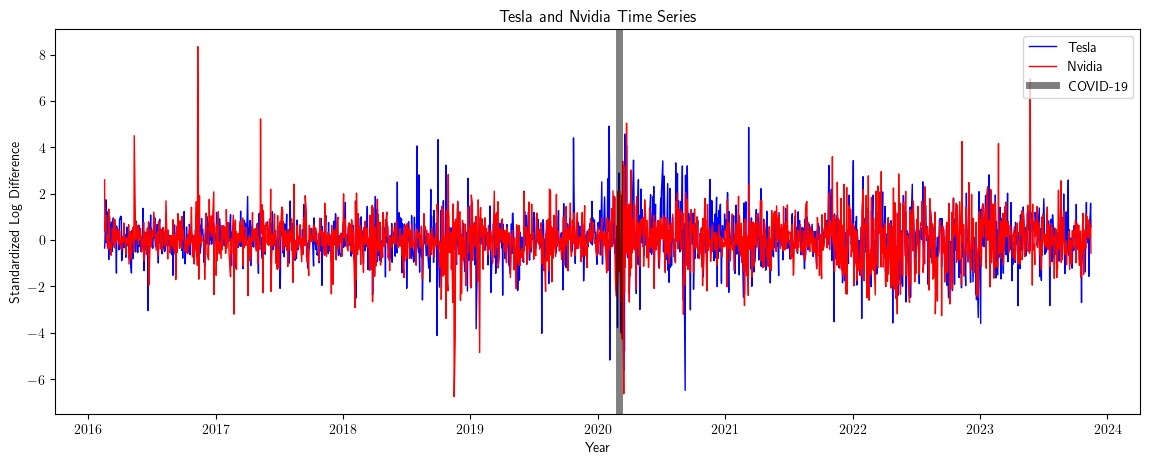

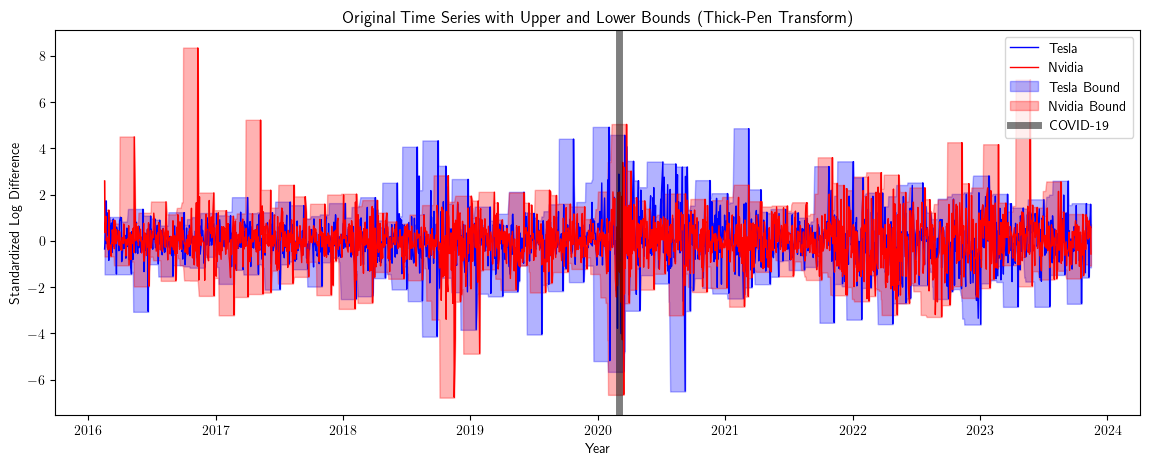

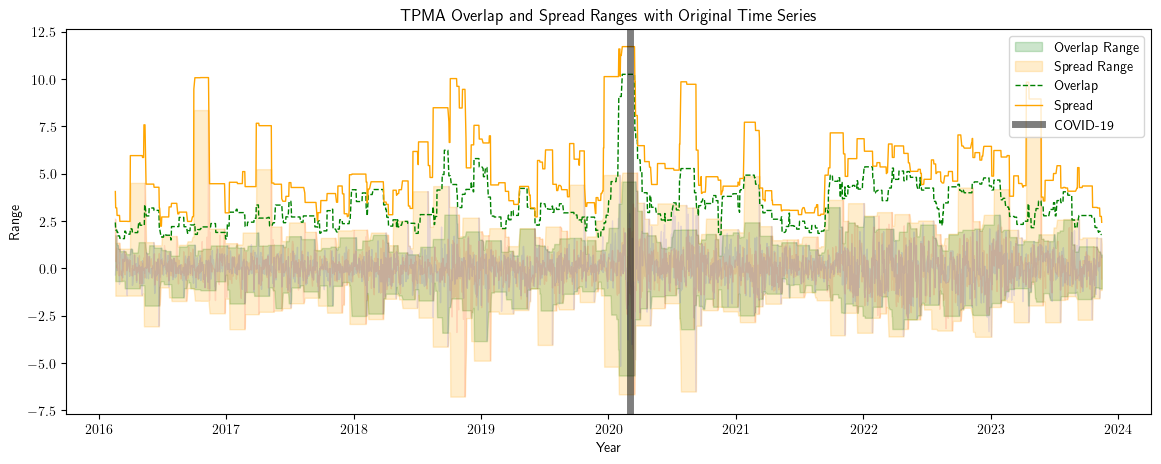

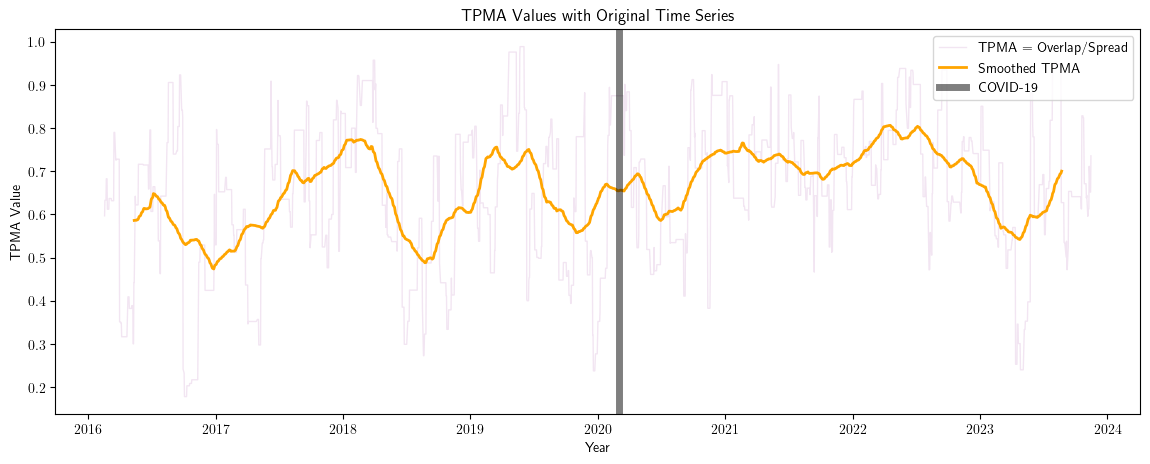

In [87]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# 데이터 크롤링 (최근 8년)
start_date = '2016-01-01'
end_date = '2024-01-01'
tesla = yf.download('TSLA', start=start_date, end=end_date)
nvidia = yf.download('NVDA', start=start_date, end=end_date)

# 로그 변환 및 차분
log_tesla = np.log(tesla['Close'])
log_nvidia = np.log(nvidia['Close'])
diff_log_tesla = log_tesla.diff().dropna()
diff_log_nvidia = log_nvidia.diff().dropna()

# 표준화
std_diff_log_tesla = standardize(diff_log_tesla)
std_diff_log_nvidia = standardize(diff_log_nvidia)

tau = 30  # 두께 파라미터 설정
X = std_diff_log_tesla.values
Y = std_diff_log_nvidia.values
dates = diff_log_tesla.index

X_L_tau, X_U_tau = thick_pen_transform(X, tau)
Y_L_tau, Y_U_tau = thick_pen_transform(Y, tau)

# 코로나 시작 지점 설정
covid_start = '2020-03-01'
covid_start_idx = np.where(dates >= covid_start)[0][0]

# Upper와 Lower 각각 시각화 함수
def plot_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(dates[tau:-tau], X[tau:-tau], label='Tesla', color='blue', linewidth=1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], label='Nvidia', color='red', linewidth=1)
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')

    plt.legend(loc='upper right')
    plt.title('Tesla and Nvidia Time Series')
    plt.xlabel('Year')
    plt.ylabel('Standardized Log Difference')
    plt.show()

# 시각화
plot_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# Upper와 Lower 각각 시각화 함수
def plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    plt.plot(dates[tau:-tau], X[tau:-tau], label='Tesla', color='blue', linewidth=1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], label='Nvidia', color='red', linewidth=1)
    
    plt.fill_between(dates[tau:-tau], X_L_tau[tau:-tau], X_U_tau[tau:-tau], color='blue', alpha=0.3, label='Tesla Bound')
    plt.fill_between(dates[tau:-tau], Y_L_tau[tau:-tau], Y_U_tau[tau:-tau], color='red', alpha=0.3, label='Nvidia Bound')
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
    
    plt.legend(loc='upper right')
    plt.title('Original Time Series with Upper and Lower Bounds (Thick-Pen Transform)')
    plt.xlabel('Year')
    plt.ylabel('Standardized Log Difference')
    plt.show()

# 시각화
plot_upper_lower_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

# TPMA의 분자와 분모 각각 시각화 함수
def plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau):
    plt.figure(figsize=(14, 5))
    
    overlap_range = [min(X_U_tau[t], Y_U_tau[t]) - max(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    spread_range = [max(X_U_tau[t], Y_U_tau[t]) - min(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
    
    plt.plot(dates[tau:-tau], X[tau:-tau], color='blue', linewidth=1, alpha=0.1)
    plt.plot(dates[tau:-tau], Y[tau:-tau], color='red', linewidth=1, alpha=0.1)
    
    # 분자와 분모에 해당하는 음영 추가
    plt.fill_between(dates[tau:-tau], [max(X_L_tau[t], Y_L_tau[t]) for t in range(tau, len(X)-tau)], 
                     [min(X_U_tau[t], Y_U_tau[t]) for t in range(tau, len(X)-tau)], color='green', alpha=0.2, label='Overlap Range')
    plt.fill_between(dates[tau:-tau], [min(X_L_tau[t], Y_L_tau[t]) for t in range(tau, len(X)-tau)], 
                     [max(X_U_tau[t], Y_U_tau[t]) for t in range(tau, len(X)-tau)], color='orange', alpha=0.2, label='Spread Range')
    
    plt.plot(dates[tau:-tau], overlap_range[tau:-tau], color='green', linestyle='--', linewidth=1, label='Overlap')
    plt.plot(dates[tau:-tau], spread_range[tau:-tau], color='orange', linestyle='-', linewidth=1, label='Spread')
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')

    plt.legend(loc='upper right')
    plt.title('TPMA Overlap and Spread Ranges with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('Range')
    plt.show()

# 시각화
plot_tpma_numerator_denominator_with_series(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau, dates, tau)

rho_values = rho_tau(X, Y, X_L_tau, X_U_tau, Y_L_tau, Y_U_tau)
# TPMA 값 시각화 함수
def plot_tpma_values_with_series(rho_values, dates, tau):
    plt.figure(figsize=(14, 5))
    
    # 원본 TPMA 값 플로팅
    plt.plot(dates[tau:-tau], rho_values[tau:-tau], label='TPMA = Overlap/Spread', color='purple', linewidth=1, alpha=0.1)
    
    # Smoothed line 추가 (이동 평균)
    window_size = 120
    smoothed_rho = np.convolve(rho_values[tau:-tau], np.ones(window_size)/window_size, mode='valid')
    plt.plot(dates[tau + window_size//2: -tau - window_size//2 + 1], smoothed_rho, label='Smoothed TPMA', color='orange', linewidth=2)
    
    # 코로나 시작 지점 하이라이트
    plt.axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
    
    plt.legend(loc='upper right')
    plt.title('TPMA Values with Original Time Series')
    plt.xlabel('Year')
    plt.ylabel('TPMA Value')
    plt.show()

# 시각화
plot_tpma_values_with_series(rho_values, dates, tau)

# 논문에 쓰는 그림

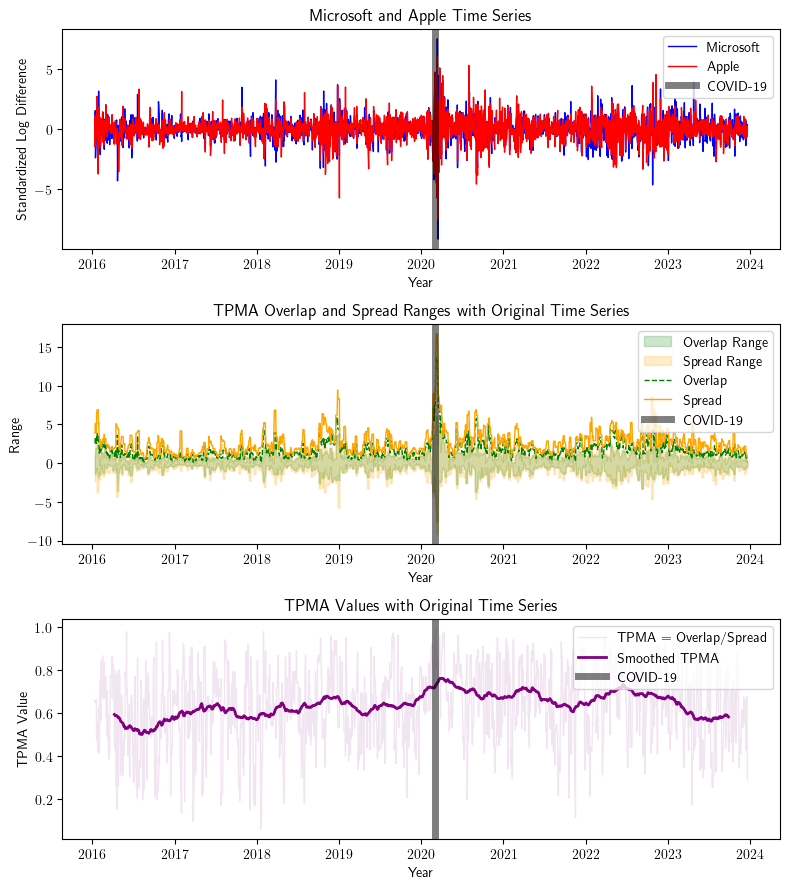

In [7]:
# 서브플롯 설정
fig, axs = plt.subplots(3, 1, figsize=(8,9))

# 첫 번째 서브플롯 - Original Time Series
axs[0].plot(dates[tau:-tau], X[tau:-tau], label='Microsoft', color='blue', linewidth=1)
axs[0].plot(dates[tau:-tau], Y[tau:-tau], label='Apple', color='red', linewidth=1)
axs[0].axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
axs[0].legend(loc='upper right')
axs[0].set_title('Microsoft and Apple Time Series')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Standardized Log Difference')

# 두 번째 서브플롯 - TPMA Overlap and Spread Ranges
overlap_range = [min(X_U_tau[t], Y_U_tau[t]) - max(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]
spread_range = [max(X_U_tau[t], Y_U_tau[t]) - min(X_L_tau[t], Y_L_tau[t]) for t in range(len(X))]

axs[1].fill_between(dates[tau:-tau], [max(X_L_tau[t], Y_L_tau[t]) for t in range(tau, len(X)-tau)], 
                     [min(X_U_tau[t], Y_U_tau[t]) for t in range(tau, len(X)-tau)], color='green', alpha=0.2, label='Overlap Range')
axs[1].fill_between(dates[tau:-tau], [min(X_L_tau[t], Y_L_tau[t]) for t in range(tau, len(X)-tau)], 
                     [max(X_U_tau[t], Y_U_tau[t]) for t in range(tau, len(X)-tau)], color='orange', alpha=0.2, label='Spread Range')
axs[1].plot(dates[tau:-tau], overlap_range[tau:-tau], color='green', linestyle='--', linewidth=1, label='Overlap')
axs[1].plot(dates[tau:-tau], spread_range[tau:-tau], color='orange', linestyle='-', linewidth=1, label='Spread')
axs[1].axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
axs[1].legend(loc='upper right')
axs[1].set_title('TPMA Overlap and Spread Ranges with Original Time Series')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Range')

# 세 번째 서브플롯 - TPMA Values
axs[2].plot(dates[tau:-tau], rho_values[tau:-tau], label='TPMA = Overlap/Spread', color='purple', linewidth=1, alpha=0.1)
window_size = 120
smoothed_rho = np.convolve(rho_values[tau:-tau], np.ones(window_size)/window_size, mode='valid')
axs[2].plot(dates[tau + window_size//2: -tau - window_size//2 + 1], smoothed_rho, label='Smoothed TPMA', color='purple', linewidth=2)
axs[2].axvline(dates[covid_start_idx], color='k', linewidth=5, alpha=0.5, label='COVID-19')
axs[2].legend(loc='upper right')
axs[2].set_title('TPMA Values with Original Time Series')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('TPMA Value')

# 전체 그림 저장
plt.tight_layout()
plt.savefig('./Dropbox/03_Yechan3/연구/교수님이랑/MS_Review/tpt_MSAPPL.pdf')
plt.show()